<a href="https://colab.research.google.com/github/the2roock/Cifar10-Classification/blob/main/Cifar10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Requirements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add, BatchNormalization, MaxPooling2D, AvgPool2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

In [2]:
# Apply Cuda
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 2. Load the CIFAR10 Dataset

In [3]:
# Data loading
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
print(f'Training set shape: X{X_train.shape}, y{y_train.shape}')
print(f'Test set shape: X{X_test.shape}, y{y_test.shape}')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Training set shape: X(50000, 32, 32, 3), y(50000, 1)
Test set shape: X(10000, 32, 32, 3), y(10000, 1)


'Horse'

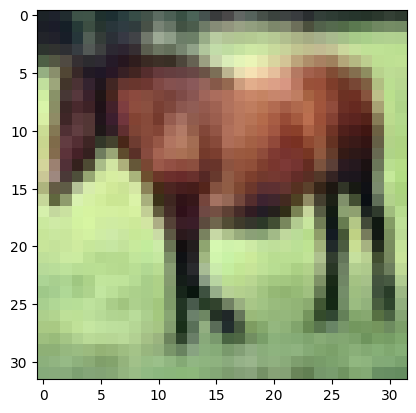

In [4]:
# Categories
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Example
example_ix = 7
plt.imshow(X_train[example_ix])
labels[y_train[example_ix][0]]

# 3. Preprocess Data

In [6]:
# Normalization
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [7]:
# One-Hot categories encoding
y_train = keras.utils.to_categorical(y_train, len(labels))
y_test = keras.utils.to_categorical(y_test, len(labels))
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [8]:
# Split trainset to training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((40000, 32, 32, 3), (40000, 10), (10000, 32, 32, 3), (10000, 10))

In [9]:
# Create data pipeline with augmentations for training process
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=.1,
    height_shift_range=.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# 4. Define a Model

In [10]:
# Function defines the model
def create_model():
    input = Input((32, 32, 3))

    # Conv Layer 1
    layer1 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(input)
    layer1 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer1)
    # Residual connect
    shortcut_input = Conv2D(64, (1, 1))(input)
    layer1 = Add()([layer1, shortcut_input])
    layer1 = BatchNormalization()(layer1)
    layer1 = MaxPooling2D((2,2))(layer1)

    # Conv Layer 2
    layer2 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer1)
    layer2 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer2)
    # Dense connect
    shortcut_input = AvgPool2D((2,2))(input)
    shortcut_input = Conv2D(128, (1, 1))(shortcut_input)
    # Residual connect
    shortcut_prev_layer = Conv2D(128, (1, 1))(layer1)
    layer2 = Add()([layer2, shortcut_input, shortcut_prev_layer])
    layer2 = BatchNormalization()(layer2)
    layer2 = MaxPooling2D((2,2))(layer2)

    # Conv Layer 3
    layer3 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer2)
    layer3 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer3)
    layer3 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer3)
    # Dense connect
    shortcut_input = AvgPool2D((4, 4))(input)
    shortcut_input = Conv2D(256, (1, 1))(shortcut_input)
    # Residual connect
    shortcut_prev_layer = Conv2D(256, (1, 1))(layer2)
    layer3 = Add()([layer3, shortcut_input, shortcut_prev_layer])
    layer3 = BatchNormalization()(layer3)
    layer3 = MaxPooling2D((2,2))(layer3)

    # Conv Layer 4
    layer4 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer3)
    layer4 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer4)
    layer4 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer4)
    # Dense connect
    shortcut_input = AvgPool2D((8, 8))(input)
    shortcut_input = Conv2D(512, (1, 1))(shortcut_input)
    # Residual connect
    shortcut_prev_layer = Conv2D(512, (1, 1))(layer3)
    layer4 = Add()([layer4, shortcut_input, shortcut_prev_layer])
    layer4 = BatchNormalization()(layer4)
    layer4 = MaxPooling2D((2,2))(layer4)

    # Conv Layer 5
    layer5 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer4)
    layer5 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer5)
    layer5 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(layer5)
    # Dense connect
    shortcut_input = AvgPool2D((16, 16))(input)
    shortcut_input = Conv2D(512, (1, 1))(shortcut_input)
    # Residual connect
    shortcut_prev_layer = Conv2D(512, (1, 1))(layer4)
    layer5 = Add()([layer5, shortcut_input, shortcut_prev_layer])
    layer5 = BatchNormalization()(layer5)
    layer5 = MaxPooling2D((2,2))(layer5)

    # Fully Connected
    out = Flatten()(layer5)
    out = Dense(1024, activation="relu")(out)
    out = Dropout(.3)(out)
    out = Dense(1024, activation="relu")(out)
    out = Dropout(.3)(out)
    out = Dense(256, activation="relu")(out)
    out = Dropout(.3)(out)
    out = Dense(10, activation="softmax")(out)

    model = Model(inputs=input, outputs=out)
    return model


In [19]:
# Model`s init and summary
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 64)     │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 64)     │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 32, 32, 64)     │              0 │ conv2d_23[0][0],       │
│                           │                        │                │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 64)     │            256 │ add_5[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_4       │ (None, 16, 16, 3)      │              0 │ input_layer_1[0][0]    │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 128)    │            512 │ average_pooling2d_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 128)    │          8,320 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 16, 16, 128)    │              0 │ conv2d_26[0][0],       │
│                           │                        │                │ conv2d_27[0][0],       │
│                           │                        │                │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 16, 16, 128)    │            512 │ add_6[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 8, 8, 128)      │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 17,001,930 (64.86 MB)

 Trainable params: 16,998,986 (64.85 MB)

 Non-trainable params: 2,944 (11.50 KB)

# 5. Train the Model

In [20]:
# Hyperparameters
batch_size = 64

learning_rate = 3e-4

In [21]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
# Fitting
epochs = 20

history1 = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 70ms/step - accuracy: 0.3246 - loss: 2.1820 - val_accuracy: 0.4860 - val_loss: 1.6534
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.5512 - loss: 1.5102 - val_accuracy: 0.6139 - val_loss: 1.3175
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.6277 - loss: 1.2480 - val_accuracy: 0.6821 - val_loss: 1.0931
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.6905 - loss: 1.0583 - val_accuracy: 0.7297 - val_loss: 0.9370
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7284 - loss: 0.9467 - val_accuracy: 0.6866 - val_loss: 1.1614
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7558 - loss: 0.8742 - val_accuracy: 0.7530 - val_loss: 0.8977
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7824 - loss: 0.7984 - val_accuracy: 0.7584 - val_loss: 0.8812
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7907 - loss: 0.7618 - val_accurac

In [23]:
# One more training
learning_rate = 1e-4
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
epochs = 10
history2 = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - accuracy: 0.9088 - loss: 0.4433 - val_accuracy: 0.8726 - val_loss: 0.5872
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9248 - loss: 0.3951 - val_accuracy: 0.8827 - val_loss: 0.5288
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9289 - loss: 0.3835 - val_accuracy: 0.8873 - val_loss: 0.5379
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.9311 - loss: 0.3725 - val_accuracy: 0.8797 - val_loss: 0.5525
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9312 - loss: 0.3614 - val_accuracy: 0.8868 - val_loss: 0.5398
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9355 - loss: 0.3517 - val_accuracy: 0.8757 - val_loss: 0.5673
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9414 - loss: 0.3338 - val_accuracy: 0.8824 - val_loss: 0.5579
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9389 - loss: 0.3399 - 

In [24]:
# The last one
learning_rate = 5e-5
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
epochs = 5
history3 = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.9532 - loss: 0.2945 - val_accuracy: 0.8879 - val_loss: 0.5630
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9584 - loss: 0.2838 - val_accuracy: 0.8943 - val_loss: 0.5330
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9600 - loss: 0.2737 - val_accuracy: 0.8901 - val_loss: 0.5381
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9613 - loss: 0.2666 - val_accuracy: 0.8907 - val_loss: 0.5532
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.9607 - loss: 0.2686 - val_accuracy: 0.8915 - val_loss: 0.5505


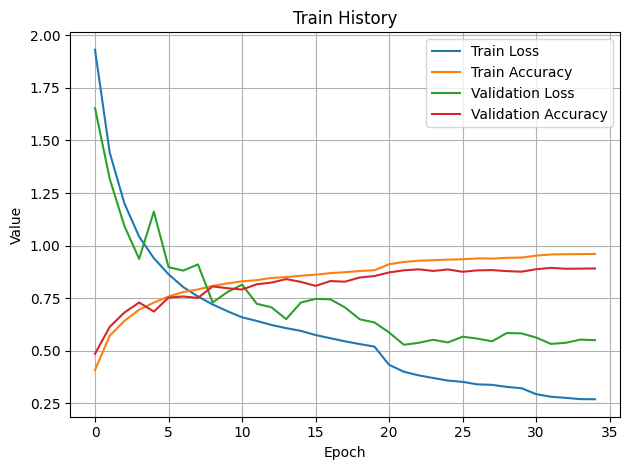

In [29]:
# Plot train results
history = {key: history1.history[key] + history2.history[key] + history3.history[key] for key in history1.history}
train_history = pd.DataFrame(history)
plt.plot(train_history.loss, label="Train Loss")
plt.plot(train_history.accuracy, label="Train Accuracy")
plt.plot(train_history.val_loss, label="Validation Loss")
plt.plot(train_history.val_accuracy, label="Validation Accuracy")
plt.grid()
plt.title("Train History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig("Train Results.png", dpi=300)

# 6. Test Model

In [30]:
# Evaluate scores
scores = model.evaluate(X_test, y_test, verbose=2)

313/313 - 2s - 8ms/step - accuracy: 0.8874 - loss: 0.5771


In [33]:
# Make classification
predicts = model.predict(X_test)
predicted_classes = np.argmax(predicts, axis=1)
true_classes = np.argmax(y_test, axis=1)
errors = predicted_classes != true_classes
print(classification_report(true_classes, predicted_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1000
           1       0.93      0.96      0.94      1000
           2       0.87      0.85      0.86      1000
           3       0.82      0.74      0.78      1000
           4       0.88      0.89      0.88      1000
           5       0.88      0.77      0.82      1000
           6       0.83      0.97      0.89      1000
           7       0.90      0.93      0.91      1000
           8       0.98      0.90      0.94      1000
           9       0.90      0.95      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



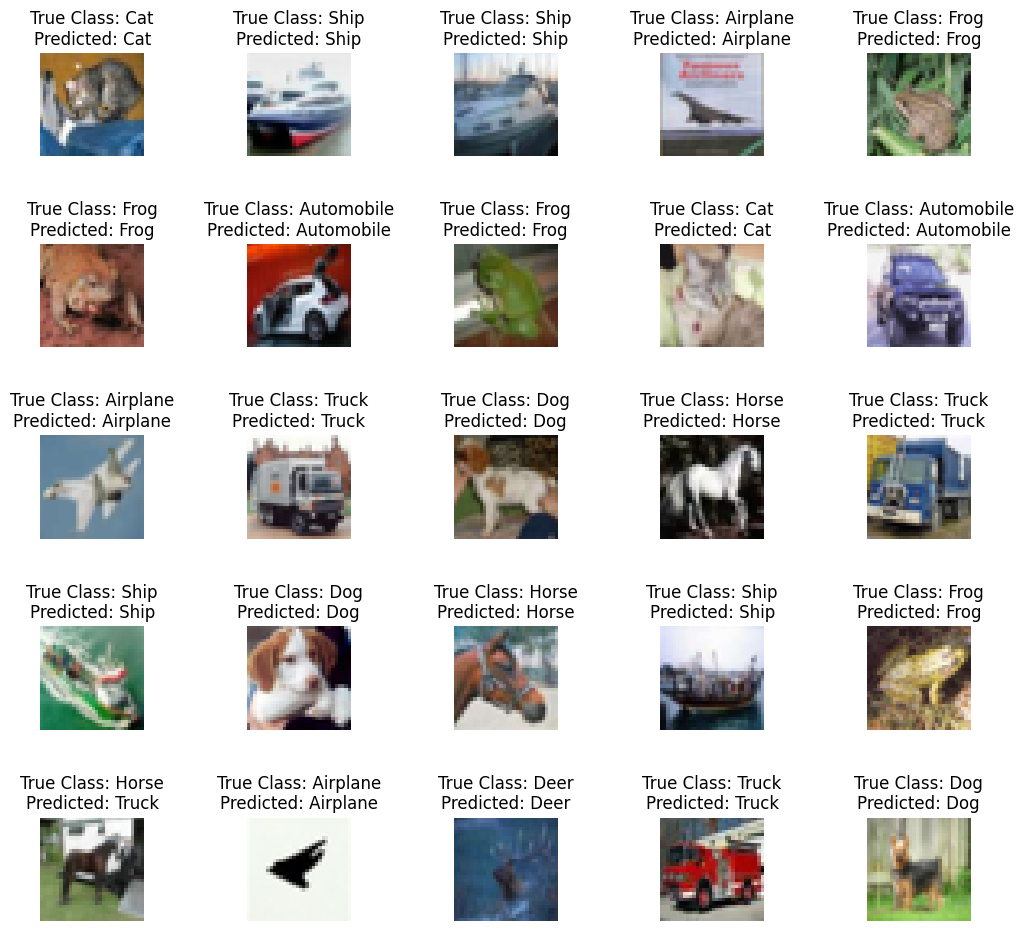

In [40]:
# Use case
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f'True Class: {labels[true_classes[i]]}\nPredicted: {labels[predicted_classes[i]]}')
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

plt.savefig("Usecase.png", dpi=300)

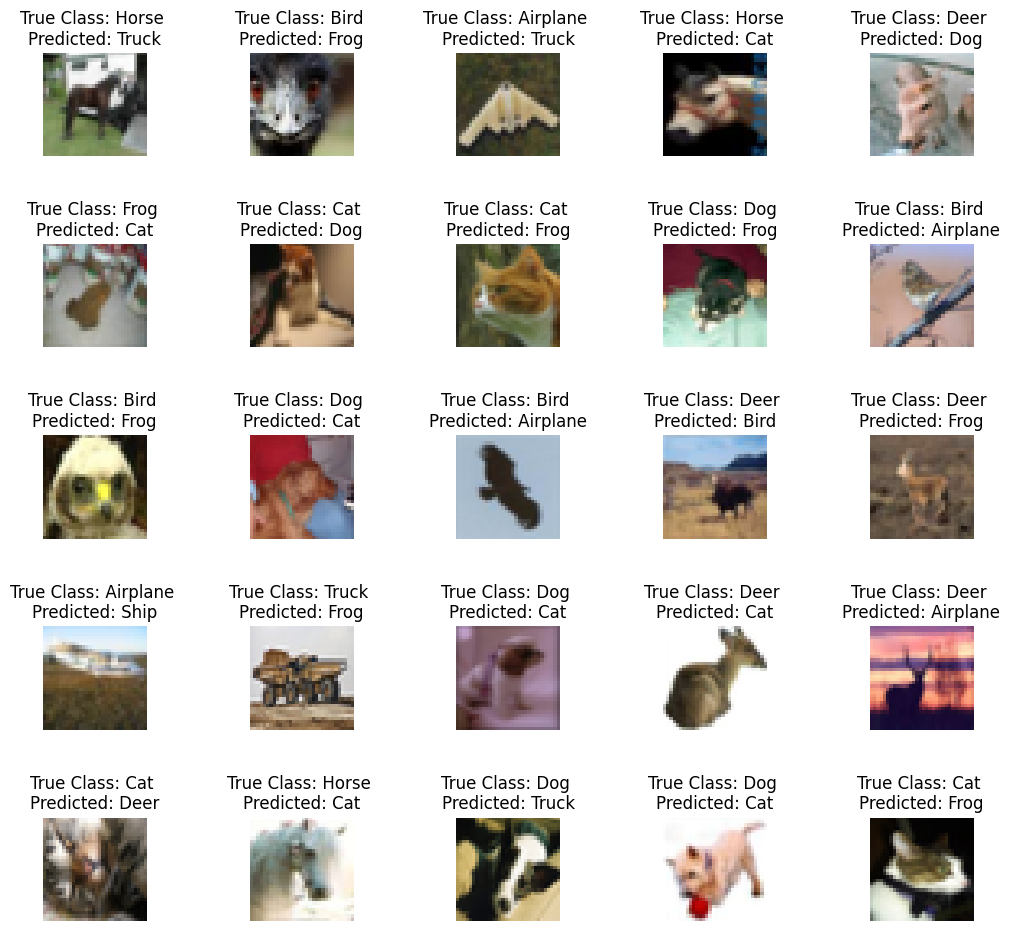

In [48]:
# Take a look at wrong predictions
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

wrong_ixs = np.where(errors)[0]
for i in np.arange(25):
    axes[i].imshow(X_test[wrong_ixs[i]])
    axes[i].set_title(f'True Class: {labels[true_classes[wrong_ixs[i]]]} \nPredicted: {labels[predicted_classes[wrong_ixs[i]]]}')
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

plt.savefig("Wrong predicts.png", dpi=300)

# 7. Save Model

In [49]:
model.save("Cifar10-CNN-Classifier 89%.keras")